We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add 'FTLE3D' folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE3D")

# Overview

In the following notebook we illustrate the numerical implementation and the use of the Mz-criterion on the three-dimensional, unsteady ABC-flow. The velocity field is given as discrete dataset defined over the 3D meshgrid $ [0,2\pi]^3 $. The notebook is structured as follows:

1. Import data from the file 'ABCunsteady.mat' stored in the folder 'data/ABC'.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. $ \mathrm{Mz-criterion} $:

    * Compute the strain acceleration tensor $ \mathbf{M}(\mathbf{x}, t) $ along every trajectory launched at $ \mathbf{x}_0 $ over the time-interval $ t \in [t_0, t_N] $.
    
    \begin{equation}
    \mathbf{M}(\mathbf{x}, t) = \dfrac{D\mathbf{S}}{Dt} + \mathbf{S}\mathbf{\nabla v}+(\mathbf{\nabla v})^T\mathbf{S}
    \end{equation}
    
    <br />
    
    * If the trajectory $ \mathbf{x}(t) $ at time $ t $ satisfies $ \mathbf{M}(\mathbf{x}, t) \succ 0 $, then it is in a hyperbolic flow region. Otherwise, if $ \mathbf{M}(\mathbf{x}, t) $ is indefinite, then it is in an elliptic flow region.
    
    * Compute the total time spent in a hyperbolic flow region ($ \tau_H $) of the trajectory $ \mathbf{x}(t) $ launched from $ \mathbf{x}_0 $ over the time-interval $ [t_0, t_N] $.
    
    * Compute the total time spent in an elliptic flow region ($ \tau_E $) of the trajectory $ \mathbf{x}(t) $ launched from $ \mathbf{x}_0 $ over the time-interval $ [t_0, t_N] $.
    
    $ \tau_H $ and $ \tau_E $ are then plotted with respect to the initial position of the particles.
    
 <br />    
6. References

# Import data

In [2]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/ABC/ABCunsteady.mat')

U = mat_file['u'] # array (NY, NX, NZ)
V = mat_file['v'] # array (NY, NX, NZ)
W = mat_file['w'] # array (NY, NX, NZ)
x = mat_file['x'] # array (1, NX)
y = mat_file['y'] # array (1, NY)
z = mat_file['z'] # array (1, NZ)
time_data = mat_file['t']

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 7 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = True # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

## Resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0] # float
dy_data = Y[1,0,0]-Y[0,0,0] # float
dz_data = Y[0,0,1]-Z[0,0,0] # float

delta = [dx_data, dy_data, dx_data] # list (3, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 20 # float

# Time step-size
dt = 0.1 # float

# NOTE: For computing the backward FTLE field tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 100 # int
Nx = 100 # int
Nz = 100 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0] # float
dy = y_domain[1]-y_domain[0] # float
dz = z_domain[1]-z_domain[0] # float

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int
Nz = X_domain.shape[2] # int

# auxiliary grid spacing
aux_grid = [0.1*dx, 0.1*dy, 0.1*dz] # list (3,)

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations, we interpolate the discrete velocity data. The interpolation with respect to time and space is linear.

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0
W[np.isnan(W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, Z, U, V, W, time_data)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# Hyperbolicity/Ellipticity time $ \tau_{\mathcal{H}}, \tau_{\mathcal{E}} $

Next, we compute the time spent in hyperbolic and elliptic flow regions by particles launched from $ \mathbf{x}_0 $ at time $ t_0 $

In [6]:
# Import function to compute trajectories/velocity along trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute gradient of velocity
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import function to compute eigenvalues
from ipynb.fs.defs.eigen import eigen

# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def tau_Hyperbolicity_Ellipticity(x0_batch, y0_batch, z0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch, z0_batch])  # array (2, Nx*Ny)
    
    # Compute velocity along trajectories
    Fmap = integration_dFdt(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady)[0] # shape (Nt, 3, Nx*Ny)

    M = np.zeros((Fmap.shape[0], 3, 3, Fmap.shape[-1]))
    
    Hyperbolicity = np.zeros((M.shape[0], M.shape[-1]))
    Ellipticity = np.zeros((M.shape[0], M.shape[-1]))
    
    for i in range(Fmap.shape[0]-1):
        
        if np.around(i/(Fmap.shape[0]-1)*100, 2) % 2 == 0:
            
            print("Percentage completed: ", np.around(i/(Fmap.shape[0]-1)*100, 2))
          
        # Compute gradient of velocity field
        grad_vel = gradient_velocity(time[i], Fmap[i,:,:], X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady, aux_grid) # (3,3,Nx*Ny)
        
        # Compute rate of strain tensor
        S = .5*(grad_vel+grad_vel.transpose(1,0,2))
        
        # Compute gradient of velocity field at t+dt in order to evaluate partial derivative of S with respect to t
        grad_vel_dt = gradient_velocity(time[i+1], Fmap[i+1,:,:], X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady, aux_grid) # (3,3,Nx*Ny)
        
        # Compute rate of strain tensor at t + dt
        S_dt = .5*(grad_vel_dt+grad_vel_dt.transpose(1,0,2))
        
        for ii in range(Fmap.shape[-1]):
        
            M[i,:,:,ii] = (S_dt[:,:,ii]-S[:,:,ii])/(time[i+1]-time[i])+S[:,:,ii]@grad_vel[:,:,ii]+grad_vel[:,:,ii].transpose()@S[:,:,ii]
            lambda_min = eigen(M[i,:,:,ii])[0][-1]
            
            if lambda_min > 0:
                Hyperbolicity[i,ii] = 1
            
            elif lambda_min < 0:
                Ellipticity[i,ii] = 1
    
    tau_Hyperbolicity = np.sum(Hyperbolicity, axis = 0)*dt
    tau_Ellipticity = np.sum(Ellipticity, axis = 0)*dt
    
    return tau_Hyperbolicity, tau_Ellipticity

## XY-plane

Compute $ \mathrm{\tau}_H, \mathrm{\tau}_E $ over the 2D meshgrid on the XY-plane.

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_xy = X_domain[:,:,-1].ravel() # array (Nx*Ny, )
y0_xy = Y_domain[:,:,-1].ravel() # array (Nx*Ny, )
z0_xy = Z_domain[:,:,-1].ravel() # array (Nx*Ny, )

x0_batch = list(split(x0_xy, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0_xy, Ncores)) # list (Nx*Ny)
z0_batch = list(split(z0_xy, Ncores)) # list (Nx*Ny)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(tau_Hyperbolicity_Ellipticity)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of hyperbolicity and ellipticity time computation on xy-plane
tau_Hyperbolicity_xy = results[0][0]
tau_Ellipticity_xy = results[0][1]
for res in results[1:]:
    tau_Hyperbolicity_xy = np.append(tau_Hyperbolicity_xy, res[0], axis = -1)
    tau_Ellipticity_xy = np.append(tau_Ellipticity_xy, res[1], axis = -1)

# reshape vectorized arrays to structured array
X0_xy = np.array(x0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Y0_xy = np.array(y0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Z0_xy = np.array(z0_xy).reshape(Ny,Nx) # array (Ny, Nx)
tau_Hyperbolicity_xy = np.array(tau_Hyperbolicity_xy).reshape(Ny,Nx) # array (Ny, Nx)
tau_Ellipticity_xy = np.array(tau_Ellipticity_xy).reshape(Ny,Nx) # array (Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:   46.9s remaining:  2.0min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:   47.2s finished


## XZ-plane

Compute $ \mathrm{\tau}_H, \mathrm{\tau}_E $ over the 2D meshgrid on the XZ-plane.

In [8]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_xz = X_domain[0,:,:].ravel() # array (Nx*Nz, )
y0_xz = Y_domain[0,:,:].ravel() # array (Nx*Nz, )
z0_xz = Z_domain[0,:,:].ravel() # array (Nx*Nz, )

x0_batch = list(split(x0_xz, Ncores)) # list (Nx*Nz)
y0_batch = list(split(y0_xz, Ncores)) # list (Nx*Nz)
z0_batch = list(split(z0_xz, Ncores)) # list (Nx*Nz)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(tau_Hyperbolicity_Ellipticity)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of hyperbolicity and ellipticity time computation on xy-plane
tau_Hyperbolicity_xz = results[0][0]
tau_Ellipticity_xz = results[0][1]
for res in results[1:]:
    tau_Hyperbolicity_xz = np.append(tau_Hyperbolicity_xz, res[0], axis = -1)
    tau_Ellipticity_xz = np.append(tau_Ellipticity_xz, res[1], axis = -1)

# reshape vectorized arrays to structured array
X0_xz= np.array(x0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Y0_xz = np.array(y0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Z0_xz = np.array(z0_xz).reshape(Nz,Nx) # array (Nz, Nx)
tau_Hyperbolicity_xz = np.array(tau_Hyperbolicity_xz).reshape(Nz,Nx) # array (Ny, Nx)
tau_Ellipticity_xz = np.array(tau_Ellipticity_xz).reshape(Nz,Nx) # array (Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:   46.8s remaining:  1.9min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:   47.1s finished


## YZ-plane

Compute $ \mathrm{\tau}_H, \mathrm{\tau}_E $ over the 2D meshgrid on the YZ-plane.

In [9]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0_yz = X_domain[:,0,:].ravel() # array (Nx*Ny, )
y0_yz = Y_domain[:,0,:].ravel() # array (Nx*Ny, )
z0_yz = Z_domain[:,0,:].ravel() # array (Nx*Ny, )

x0_batch = list(split(x0_yz, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0_yz, Ncores)) # list (Nx*Ny)
z0_batch = list(split(z0_yz, Ncores)) # list (Nx*Ny)
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(tau_Hyperbolicity_Ellipticity)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of hyperbolicity and ellipticity time computation on xy-plane
tau_Hyperbolicity_yz = results[0][0]
tau_Ellipticity_yz = results[0][1]
for res in results[1:]:
    tau_Hyperbolicity_yz = np.append(tau_Hyperbolicity_yz, res[0], axis = -1)
    tau_Ellipticity_yz = np.append(tau_Ellipticity_yz, res[1], axis = -1)

# reshape vectorized arrays to structured array
X0_yz= np.array(x0_yz).reshape(Nz,Ny) # array (Nz, Nx)
Y0_yz = np.array(y0_yz).reshape(Nz,Ny) # array (Nz, Nx)
Z0_yz = np.array(z0_yz).reshape(Nz,Ny) # array (Nz, Nx)
tau_Hyperbolicity_yz = np.array(tau_Hyperbolicity_yz).reshape(Nz,Ny) # array (Ny, Nx)
tau_Ellipticity_yz = np.array(tau_Ellipticity_yz).reshape(Nz,Ny) # array (Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:   46.2s remaining:  1.9min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:   46.3s finished


###### Hyperbolicity time $ \tau_H $

In [ ]:
# Import plotly for 3D figures
from plotly import graph_objs as go

# define minimum and maximum values for colorbar
min_value = min(np.min(tau_Hyperbolicity_yz),min(np.min(tau_Hyperbolicity_xy), np.min(tau_Hyperbolicity_xz)))
max_value = max(np.max(tau_Hyperbolicity_yz),max(np.max(tau_Hyperbolicity_xy), np.max(tau_Hyperbolicity_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = tau_Hyperbolicity_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = tau_Hyperbolicity_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = tau_Hyperbolicity_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = tau_Hyperbolicity_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = tau_Hyperbolicity_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = tau_Hyperbolicity_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.show()

In [10]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '$x=0$ section')

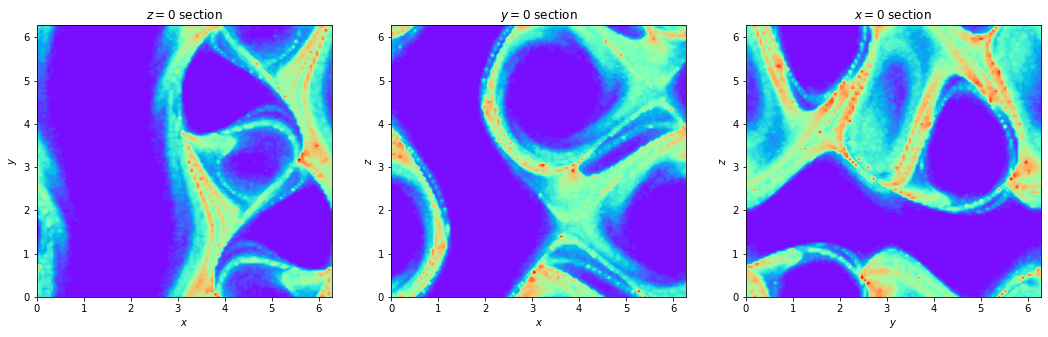

In [11]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, tau_Hyperbolicity_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, tau_Hyperbolicity_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, tau_Hyperbolicity_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

###### Ellipticity time $ \tau_E $

In [ ]:
# Import plotly for 3D figures
from plotly import graph_objs as go

# define minimum and maximum values for colorbar
min_value = min(np.min(tau_Ellipticity_yz),min(np.min(tau_Ellipticity_xy), np.min(tau_Ellipticity_xz)))
max_value = max(np.max(tau_Ellipticity_yz),max(np.max(tau_Ellipticity_xy), np.max(tau_Ellipticity_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = tau_Ellipticity_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = tau_Ellipticity_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = tau_Ellipticity_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy-2*np.pi, surfacecolor = tau_Ellipticity_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = tau_Ellipticity_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = tau_Ellipticity_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.show()

Text(0.5, 1.0, '$x=0$ section')

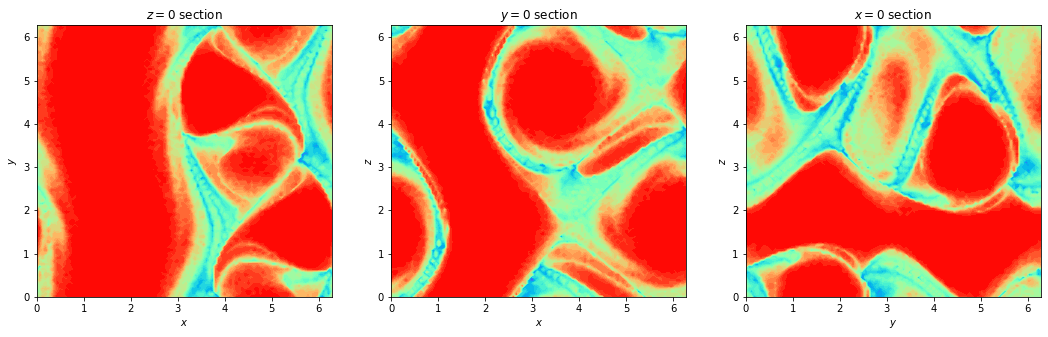

In [12]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, tau_Ellipticity_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, tau_Ellipticity_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, tau_Ellipticity_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

The total time spent inside hyperbolic/elliptic regions is plotted with respect to initial positions.

# References

[1] Haller, G. (2001). Lagrangian structures and the rate of strain in a partition of two-dimensional turbulence. Physics of Fluids, 13(11), 3365-3385.

[2] Notebook 5.6.2 in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.